In [25]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from functools import partial 
import seaborn as sb

from scikeras.wrappers import KerasRegressor



# Comparison of Regressors for Abalone Age Prediction

In this assignment, the objective is to compare the performance of different regressors on the Abalone dataset. What is the best algorithm for the dataset? How does ANNs compare to other ML methods? What is the best ANN architecture?

In [26]:
abalone_data = pd.read_csv('data/abalone.data')
abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Introduction
This is an extension of Supervised Learning II: Regressors for abalone age. In this project, I will use the same dataset but apply Artificial Neural Networks (ANNs) to evaluate their performance and compare the results to those obtained with previous methods. Since I already conducted exploratory data analysis in the previous assignment, I will reuse the same preprocessing steps and pipelines. To maintain better organization, I will keep this extended assignment in a separate file. 
  
The models I will be comparing are the MLPRegressor and Keras Sequential models with two different architectures.

The steps i will follow in this assignment:  
        1. Hyperparameter Tuning: I will be using nested grid search to find the best parameters for each model  
        2. Model evaluation: evaluating using accuracy, precision, recall, the f-measure and roc-auc to conclude which is the best model. 

# preprocessing of data

# encoding categorical value
to make it easier for the functions used later

In [27]:
label_encoder = LabelEncoder()

abalone_data['M'] = label_encoder.fit_transform(abalone_data['M'])

abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# 

# pipe with changed data
Standardizing the data is important for training Artificial Neural Networks (ANNs) because they tend to work better when the input features are on a similar scale. Even though the dataset was scaled by dividing by 200, that’s not quite the same as standardizing (which involves adjusting the data so it has a mean of 0 and a standard deviation of 1). So, just to be safe, I'll go ahead and standardize the data properly to make sure it works well with the neural network.
  
I will test the models with only standarizaing the data, then with standarizaing and pca together since pca works better with standarizaing

In [28]:
def pipe_with_scaler(model):
    return Pipeline([('scaler', StandardScaler()), ('regressor', model)])

In [29]:
pca = ColumnTransformer([
     ("pca", PCA(3), [1,2,4,5,6])], remainder='passthrough')

def pipe_with_scaler_and_pca(model):
    return Pipeline([('scaler', StandardScaler()), ('pca', pca),('regressor', model)])

# Split the dataset into suitable partitions

In [30]:
features = abalone_data.drop('15', axis=1)
targets = abalone_data['15']

train_val_features, test_features, train_val_targets, test_targets = train_test_split(features, targets, test_size=0.2)

In [31]:
print(train_val_features.shape, train_val_targets.shape, test_features.shape, test_targets.shape)

(3340, 8) (3340,) (836, 8) (836,)


# Making the models and parameter tuning
I will test the models in two rounds. In the first round, I will evaluate which dataset provides the best results for the models. In the second round, I will take the best-performing model and dataset combination and fine-tune the parameters to achieve the optimal results.


# Round One: Finding the dataset for the models
In this round, I will determine which alterations of the dataset yield the best results. I will test every model with each dataset variation. Once I identify the best-performing dataset, I will use it to fine-tune the models' parameters. This approach reduces runtime by allowing me to focus first on selecting the optimal dataset before delving into parameter optimization. For now, I will test simple models with default parameters.

# function to evaluate

In [32]:

def evaluate(estimator, X, y):
    predictions = estimator.predict(X)
    return {
        'r2': r2_score(y, predictions), 
        'mean_absolute_error': mean_absolute_error(y, predictions), 
        'mean_squared_error': mean_squared_error(y, predictions)
    }

# MLP regressor
I will first test the MLP regressor. This is a type of neural network that can be used like any other classifier, even though it is based on a neural network architecture. It is a feedforward neural network that uses dense layers.
The MLP classifier is particularly useful for a variety of reasons, it is used to learn non-linear relationships and see more complex patterns.

# MLP with original dataset

In [33]:
mlp_model = MLPRegressor(max_iter=1000).fit(train_val_features, train_val_targets)
evaluate(mlp_model, test_features, test_targets)

{'r2': 0.5457128125825467,
 'mean_absolute_error': 1.5682787403762801,
 'mean_squared_error': 4.728380579122056}

# MLP with scaling

In [34]:
mlp_model1 = MLPRegressor(max_iter=1000)

mlp_pipe1 = pipe_with_scaler(mlp_model1)
mlp_pipe1.fit(train_val_features, train_val_targets)
evaluate(mlp_pipe1, test_features, test_targets)

{'r2': 0.5713782930249957,
 'mean_absolute_error': 1.5104247027099924,
 'mean_squared_error': 4.4612452457048795}

# MLP with scaling and pca

In [35]:
mlp_model2 = MLPRegressor(max_iter=1000)

mlp_pipe2 = pipe_with_scaler_and_pca(mlp_model2)
mlp_pipe2.fit(train_val_features, train_val_targets)
evaluate(mlp_pipe2, test_features, test_targets)

{'r2': 0.5524872073330305,
 'mean_absolute_error': 1.5268607479511085,
 'mean_squared_error': 4.6578702995881125}

# Sequential model 1 with simple architecture
For the first sequential model, I am using a simpler architecture with only dense layers. The dense layer is commonly used in neural networks to connect every neuron in one layer to every neuron in the next layer, making it a fully connected layer

# Sequential model 1 with orignal dataset

In [36]:
sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])
sequential_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

sequential_model1.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)
evaluate(sequential_model1, test_features, test_targets)

Epoch 1/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 34.4427 - mae: 4.3351
Epoch 2/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - loss: 7.0147 - mae: 1.9194
Epoch 3/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 6.1121 - mae: 1.7796
Epoch 4/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - loss: 5.8373 - mae: 1.7431
Epoch 5/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 5.7471 - mae: 1.7173
Epoch 6/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 5.4333 - mae: 1.6977
Epoch 7/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - loss: 4.7661 - mae: 1.5593
Epoch 8/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - loss: 5.1526 - mae: 1.6310
Epoch 9/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 5.1647 - mae: 1.6397
Epoch 10/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - loss: 5.1274 - mae: 1.6248
Epoch 11/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - loss: 4.6372 - mae: 1.5529
Epoch 12/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - loss: 4.9190 - mae: 1.6009


{'r2': 0.5224894285202026,
 'mean_absolute_error': 1.6819654399056754,
 'mean_squared_error': 4.970097853618263}

# Sequential model 1 with scaling

In [37]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
    sequential_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model1

model1 = KerasRegressor(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe1 = pipe_with_scaler(model1)


sequential_model1_pipe1.fit(train_val_features, train_val_targets)
evaluate(sequential_model1_pipe1, test_features, test_targets)


{'r2': 0.5541608929634094,
 'mean_absolute_error': 1.498119696903457,
 'mean_squared_error': 4.640450288893151}

# Sequential model 1 with scaling and pca

In [38]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(6,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
    sequential_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model1

model2 = KerasRegressor(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe2 = pipe_with_scaler_and_pca(model2)


sequential_model1_pipe2.fit(train_val_features, train_val_targets)
evaluate(sequential_model1_pipe2, test_features, test_targets)


{'r2': 0.5409600734710693,
 'mean_absolute_error': 1.5452278233601147,
 'mean_squared_error': 4.77784957004536}

# sequential model 2 with dropout and dense layer
For the second sequential model, I am testing a combination of dense layers and a dropout layer. The dense layer is commonly used in neural networks to connect every neuron in one layer to every neuron in the next layer, making it a fully connected layer. The dropout layer, on the other hand, is used to prevent overfitting by randomly setting a fraction of the input units to zero during training, which helps the model generalize better. By using both layers, I aim to create a balanced architecture that can learn effectively while avoiding overfitting

# sequential model 2 with orignal dataset

In [39]:
sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])

sequential_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

sequential_model2.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)
evaluate(sequential_model2, test_features, test_targets)

Epoch 1/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step - loss: 33.8848 - mae: 4.4219
Epoch 2/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - loss: 7.1968 - mae: 1.9761
Epoch 3/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - loss: 7.8815 - mae: 2.0380
Epoch 4/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - loss: 6.8997 - mae: 1.9308
Epoch 5/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - loss: 7.0409 - mae: 1.9105
Epoch 6/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - loss: 6.3317 - mae: 1.8461
Epoch 7/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - loss: 6.6562 - mae: 1.9031
Epoch 8/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - loss: 6.7355 - mae: 1.8894
Epoch 9/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - loss: 6.5208 - mae: 1.8686
Epoch 10/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - loss: 6.2740 - mae: 1.8189
Epoch 11/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - loss: 6.4158 - mae: 1.8751
Epoch 12/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - loss: 6.0981 - mae: 1.7868


{'r2': 0.4797648787498474,
 'mean_absolute_error': 1.553566007522875,
 'mean_squared_error': 5.414790249209482}

# sequential model 2 with orignal scaling

In [40]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])
    sequential_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model2

model1 = KerasRegressor(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe1 = pipe_with_scaler(model1)


sequential_model2_pipe1.fit(train_val_features, train_val_targets)
evaluate(sequential_model2_pipe1, test_features, test_targets)


{'r2': 0.5424095392227173,
 'mean_absolute_error': 1.5327398959529457,
 'mean_squared_error': 4.762762023623958}

# sequential model 2 with orignal scaling and pca

In [41]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(6,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])
    sequential_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model2

model1 = KerasRegressor(model=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe2 = pipe_with_scaler_and_pca(model1)


sequential_model2_pipe2.fit(train_val_features, train_val_targets)
evaluate(sequential_model2_pipe2, test_features, test_targets)


{'r2': 0.5312380790710449,
 'mean_absolute_error': 1.5517798217289756,
 'mean_squared_error': 4.879038807037329}

# all the results from round one:

In [42]:
print("MLP classifier")
print("Original dataset:")
print(evaluate(mlp_model, test_features, test_targets))
print("scaled dataset:")
print(evaluate(mlp_pipe1, test_features, test_targets))
print("scaled and pca dataset:")
print(evaluate(mlp_pipe2, test_features, test_targets))
print()
print("Sequential model architecture 1")
print("Original dataset:")
print(evaluate(sequential_model1, test_features, test_targets))
print("scaled dataset:")
print(evaluate(sequential_model1_pipe1, test_features, test_targets))
print("scaled and pca dataset:")
print(evaluate(sequential_model1_pipe2, test_features, test_targets))
print()
print("Sequential model architecture 2")
print("Original dataset:")
print(evaluate(sequential_model2, test_features, test_targets))
print("scaled dataset:")
print(evaluate(sequential_model2_pipe1, test_features, test_targets))
print("scaled and pca dataset:")
print(evaluate(sequential_model2_pipe2, test_features, test_targets))

MLP classifier
Original dataset:
{'r2': 0.5457128125825467, 'mean_absolute_error': 1.5682787403762801, 'mean_squared_error': 4.728380579122056}
scaled dataset:
{'r2': 0.5713782930249957, 'mean_absolute_error': 1.5104247027099924, 'mean_squared_error': 4.4612452457048795}
scaled and pca dataset:
{'r2': 0.5524872073330305, 'mean_absolute_error': 1.5268607479511085, 'mean_squared_error': 4.6578702995881125}

Sequential model architecture 1
Original dataset:
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{'r2': 0.5224894285202026, 'mean_absolute_error': 1.6819654399056754, 'mean_squared_error': 4.970097853618263}
scaled dataset:
{'r2': 0.5541608929634094, 'mean_absolute_error': 1.498119696903457, 'mean_squared_error': 4.640450288893151}
scaled and pca dataset:
{'r2': 0.5409600734710693, 'mean_absolute_error': 1.5452278233601147, 'mean_squared_error': 4.77784957004536}

Sequential model architecture 2
Original dataset:
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step
{'r2': 0.4797648787498474, 'mean_absolu

It looks like all models achieved the best results with the scaled dataset. The scaled and PCA dataset produced a little lower results, indicating that PCA did not have a positive effect on performance. Therefore, we can conclude that PCA is not really necessary for improving the results in this case.

# Round two of finding the best models

# function for grid search
I am using a normal grid search function, this will help me find the best models by finding the best parameter combinations. i wanted to use neted grid search which is even better to find the best parameters, but too high runtime.

In [8]:
def find_best_models(model, dt_params):
    metrics = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'r2': [],
        'mean_absolute_error': [],
        'mean_squared_error': []
    }


    dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='r2',return_train_score=True)
    dt_grid.fit(train_val_features, train_val_targets)

    cv_results = pd.DataFrame(dt_grid.cv_results_)
    dt_cv_results.append(cv_results)
    dt_estimators.append(dt_grid.best_estimator_)

    evaluation = evaluate(dt_grid, train_val_features, train_val_targets)
    dt_test_scores['r2'].append(evaluation['r2'])
    dt_test_scores['mean_absolute_error'].append(evaluation['mean_absolute_error'])
    dt_test_scores['mean_squared_error'].append(evaluation['mean_squared_error'])
    return dt_estimators, dt_cv_results, dt_test_scores



# MLP regressor
parameters i will tune:  
hidden_layer_sizes: Defines the number of hidden layers and neurons, affecting the model's complexity and learning capacity.
  
activation: Specifies the activation function for hidden layers, introducing non-linearity to improve learning (e.g., 'relu', 'tanh', 'logistic').
  
solver: Determines the optimization method used to minimize the loss function (e.g., 'sgd', 'adam').
  
max_iter: Sets the maximum number of iterations. If the model doesn't converge, early stopping is enabled to prevent unnecessary training


In [9]:
MLP_params = {
        'regressor__hidden_layer_sizes': [(50,), (80,), (100,), (150,)],
        'regressor__activation': ['logistic', 'tanh', 'relu'],
        'regressor__solver': ['sgd', 'adam'],
        'regressor__max_iter': [200, 300, 500],
        'regressor__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
        'regressor__n_iter_no_change': [10]
    }
best_models_mlp_model, cv_results_MLP, model_scores_MLP = find_best_models(pipe_with_scaler(MLPRegressor(early_stopping=True)), MLP_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warni

In [10]:
print(best_models_mlp_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 MLPRegressor(alpha=0.1, early_stopping=True,
                              hidden_layer_sizes=(50,), solver='sgd'))])]


In [11]:
best_mlp_model = best_models_mlp_model[0]
evaluate(best_mlp_model, test_features, test_targets)

{'r2': 0.44367875262049705,
 'mean_absolute_error': 1.5223456855672977,
 'mean_squared_error': 5.668439699730411}

# Sequential model


# Sequential model architecture 1
The parameters i am tuning:  
optimizer: Determines how the model updates its weights during training (e.g., 'adam', 'sgd').
  
epochs: The number of complete passes through the dataset during training.
  
batch size: The number of training samples processed before updating the model's weights.
  
number of hidden layers: Controls the depth of the network, influencing the model's complexity.
  
number of neurons in the layers: Defines the size of each layer, impacting how many details the model can capture.  


In [12]:
def create_model(hidden_layers=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential({tf.keras.layers.Input(shape=(8,))})
    
    for _ in range(hidden_layers - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


param_grid = {
    'regressor__model__optimizer': ['adam', 'sgd', 'rmsprop'],
    'regressor__epochs': [10, 20, 50],
    'regressor__batch_size': [16, 32, 64,],
    'regressor__hidden_layers': [10, 20, 30],
    'regressor__num_neurons': [32, 64, 128]
}


model = KerasRegressor(model=create_model, hidden_layers=1, num_neurons=128 ,verbose=0)

pipeline = pipe_with_scaler(model)
best_models_S_model, cv_results_1, model_scores = find_best_models(pipeline, param_grid)
    



c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
 

In [13]:
print(best_models_S_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KerasRegressor(batch_size=16, epochs=20, hidden_layers=30, model=<function create_model at 0x000002257C49CB80>, model__optimizer='adam', num_neurons=32, verbose=0))])]


In [14]:
best_model_sequential1 = best_models_S_model[0]

In [15]:
evaluate(best_model_sequential1, test_features, test_targets)

{'r2': 0.3128986954689026,
 'mean_absolute_error': 1.9917471026689813,
 'mean_squared_error': 7.000975835193413}

# sequantial model 2
Additionally, I am tuning the following parameters:  
drop_out: The percentage of neurons to be dropped during training to prevent overfitting.  
hidden_layers_drop_out: The number of hidden layers to retain after each dense layer, which affects the depth of the model.

In [16]:
def create_model(drop_out=0.1, hidden_layers_dens=1, hidden_layers_drop_out=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential([ 
        tf.keras.layers.Input(shape=(8,)), 
    ])
    for _ in range(hidden_layers_dens):
        model.add(Dense(num_neurons, activation=activation))
        if hidden_layers_drop_out > 0:
            model.add(Dropout(drop_out))
    
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


param_grid = {
    'regressor__optimizer': ['adam', 'sgd',],
    'regressor__epochs': [10, 20,  50],
    'regressor__batch_size': [32, 64],
    'regressor__hidden_layers_dens': [1, 3],
    'regressor__hidden_layers_drop_out': [1, 3],
    'regressor__num_neurons': [64, 128],
    'regressor__drop_out': [0.1, 0.3]
}


model = KerasRegressor(model=create_model, drop_out=0.1, hidden_layers_dens=1, hidden_layers_drop_out=1, num_neurons=128 ,verbose=0)

pipeline = pipe_with_scaler(model)
best_models_S_model, cv_results_2, model_scores_2 = find_best_models(pipeline, param_grid)



c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [17]:
best_model_sequential2 = best_models_S_model[0]
evaluate(best_model_sequential2, test_features, test_targets)

{'r2': 0.530633807182312,
 'mean_absolute_error': 1.6250219122644818,
 'mean_squared_error': 4.782441710581293}

# Comparing the results of the best models found

In [18]:
print("best MLP model")
print(evaluate(best_mlp_model, test_features, test_targets))
print()
print("best sequential model with the first architecture")
print(evaluate(best_model_sequential1, test_features, test_targets))
print()
print("best sequential model with the second arthitecture")
print(evaluate(best_model_sequential2, test_features, test_targets))

best MLP model
{'r2': 0.44367875262049705, 'mean_absolute_error': 1.5223456855672977, 'mean_squared_error': 5.668439699730411}

best sequential model with the first architecture
{'r2': 0.3128986954689026, 'mean_absolute_error': 1.9917471026689813, 'mean_squared_error': 7.000975835193413}

best sequential model with the second arthitecture
{'r2': 0.530633807182312, 'mean_absolute_error': 1.6250219122644818, 'mean_squared_error': 4.782441710581293}


# visuallizing the results

# best MLP model

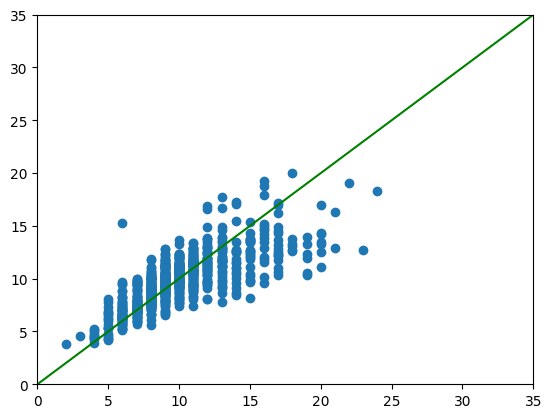

In [22]:
plt.scatter(test_targets, best_mlp_model.predict(test_features))
plt.plot([0, 35], [0, 35], c='green')
plt.axis((0, 35, 0, 35))
plt.show()

# best sequential model with the first architecture

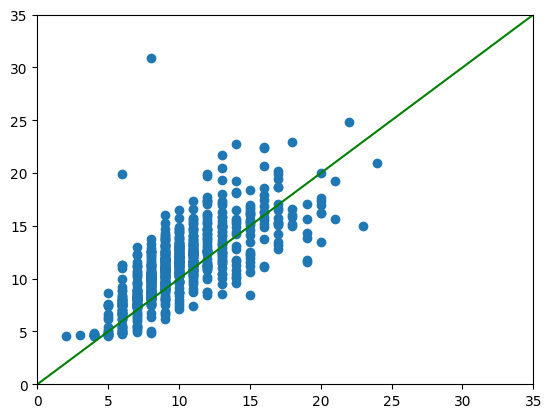

In [23]:
plt.scatter(test_targets, best_model_sequential1.predict(test_features))
plt.plot([0, 35], [0, 35], c='green')
plt.axis((0, 35, 0, 35))
plt.show()

# best sequential model with the second arthitecture

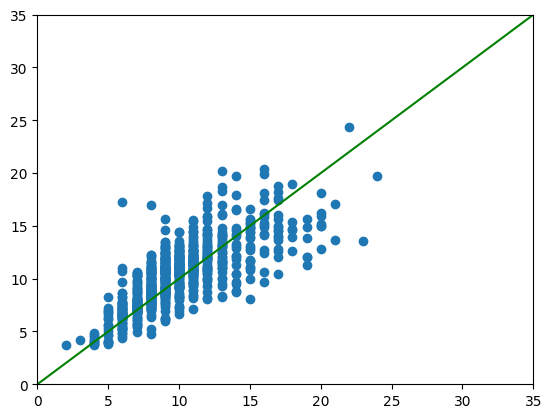

In [24]:
plt.scatter(test_targets, best_model_sequential2.predict(test_features))
plt.plot([0, 35], [0, 35], c='green')
plt.axis((0, 35, 0, 35))
plt.show()

# Conclusion
Results from round one:    
The scaled dataset yielded the best results, as observed in round one. Scaling is particularly advantageous when working with Artificial Neural Networks because it helps the model converge more efficiently and enhances overall performance. This approach showed a noticeable improvement compared to using the original dataset. However, applying PCA slightly lowered the scores in most cases. The mlp regressor got the vest results, follow by sequential model with architecutre 1 then sequential model with architecutre 2.
  
metric results from round two: 
From the metric results in round two, we can see that the sequential model with architecture 2 achieved the best performance. The MLP model and the sequential model with architecture 1 had lower results. This outcome differs from round one, where the MLP model produced the best results. The discrepancy could be due to the range of layers chosen for tuning in round two, which might have been too high for the MLP and sequential model 1. These results suggest that, for this dataset, models with a lower number of layers performed significantly better.   

  
Visuall results from round two: 
Looking at the graphs at first glance we can see that the best model sequential 1 had the most outliers. the sequential model 2 and mlp regressor look very similar, suggesting that both models fit the data well. While there are small differences between the models, it’s difficult to definitively determine which one is better based on these visuals alone.

  
The best model:  
In round one, the MLP regressor emerged as the best model. However, when I adjusted the parameters in round two, the results shifted. Overall, the MLP regressor likely would have remained the best model if I had used the same lower range of parameters as I did for sequential model 2. This suggests that parameter tuning significantly impacted the model's performance.
  
  
Things to consider with these results:
  
I could have explored more parameters, but the process was very time-consuming, so I may not have found the absolute best models for each type. The Keras models, in particular, had extremely high runtimes, even when using a regular grid search instead of a nested one. I would have liked to experiment with different architectures, such as varying the number of layers and testing more hyperparameters, but I was constrained by time. Alternatively, I could have used RandomizedSearchCV, which is faster, but it does not guarantee finding the best model since it only samples a subset of the parameter space.
  
 
Compare results to regular sklearn models from supervised learning II:
When comparing the results to the regular sklearn models from Supervised Learning II, random forest regressor with original data performed a bit better. Random Forests tend to work well for regression problems like this one, especially when the data has a mix of features and complex relationships. On the other hand, ANNs are better suited for more complex problems like image recognition, where the relationships between features are more intricate. In this case, the Random Forest model’s simpler structure made it a better fit for this dataset, so I’d go with that over the ANN



# Sources
GeeksforGeeks. (n.d.). How to rename columns in pandas dataframe. Retrieved from https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/
  
Scikit-learn Documentation. (n.d.). MLPRegressor. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPRegressor.html
  
PyTorch. (n.d.). Deep learning with PyTorch: A 60-minute blitz. Retrieved from https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
  
Raza, A. (2020, March 16). Hyperparameter tuning with Keras and GridSearchCV: A comprehensive guide. Medium. Retrieved from https://medium.com/@AIandInsights/hyperparameter-tuning-with-keras-and-gridsearchcv-a-comprehensive-guide-46214cc0d999
  
Stack Overflow. (2018, March 25). Grid search the number of hidden layers with Keras. Stack Overflow. Retrieved from https://stackoverflow.com/questions/47788799/grid-search-the-number-of-hidden-layers-with-keras

Scikit-learn Documentation: StandardScaler
Scikit-learn. (2024). StandardScaler. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html
    
Medium Article: Introduction to Machine Learning Pipelines
Jang, C. (2020, November 17). Introduction to machine learning pipelines. Medium. Retrieved from https://medium.com/@cezinejang/introduction-to-machine-learning-pipelines-adb041120856
    
StackOverflow: Precision Calculation Warning
StackOverflow. (2020, May 13). Precision calculation warning when using GridSearchCV for logistic regression. Retrieved from https://stackoverflow.com/questions/66538197/precision-calculation-warning-when-using-gridsearchcv-for-logistic-regression
    
Scikit-learn. (2024). GridSearchCV. Retrieved from https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html